# Libraries

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from config import *

from keras.layers import LSTM, Dense, Dropout
from keras.models import Sequential

from sklearn.model_selection import train_test_split

# Read data

In [9]:
data_dir = '../data'
files = os.listdir(data_dir)

df = {}
for path in files:
    className = path.split('.')[0]
    df[className] = pd.read_csv(os.path.join(data_dir,path))

classes = list(df.keys())
print("Classes: {}".format(classes))
print(df[classes[0]].head(3))

Classes: ['Swing_hand', 'Nod_head']
          0         1         2         3         4         5         6  \
0  0.542020  0.564723 -1.102557  0.999961  0.573140  0.499020 -1.057262   
1  0.543472  0.545153 -1.138825  0.999957  0.577044  0.484092 -1.081547   
2  0.544545  0.536801 -1.134046  0.999956  0.578777  0.477000 -1.079495   

          7         8         9  ...       122       123       124       125  \
0  0.999924  0.592175  0.501668  ...  1.223186  0.000012  0.660932  2.967199   
1  0.999918  0.595909  0.488044  ...  0.901236  0.000014  0.672671  2.960815   
2  0.999915  0.597525  0.480905  ...  0.985008  0.000015  0.672196  2.953565   

        126       127       128       129       130       131  
0  0.315049  0.000037  0.487768  2.957272  0.540598  0.000037  
1  0.291029  0.000040  0.501141  2.952441  0.210714  0.000041  
2  0.291966  0.000042  0.500692  2.946454  0.298201  0.000043  

[3 rows x 132 columns]


# Create train X, Y

In [10]:
nClass = len(classes)

X = []
y = []

for idx, className in enumerate(classes):
    nSample = len(df[className])
    for start in range(nSample-N_TIME):
        X.append(df[className].iloc[start:start+N_TIME,:])
        one_hot = [0]*nClass
        one_hot[idx] = 1
        y.append(one_hot)

X, y = np.array(X), np.array(y)

print("X shape: {}".format(X.shape))
print("y shape: {}".format(y.shape))

X shape: (1180, 10, 132)
y shape: (1180, 2)


# Train test split

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

print("[Train]")
print("X shape: {}".format(X_train.shape))
print("y shape: {}".format(y_train.shape))

print("[Test]")
print("X shape: {}".format(X_test.shape))
print("y shape: {}".format(y_test.shape))

[Train]
X shape: (944, 10, 132)
y shape: (944, 2)
[Test]
X shape: (236, 10, 132)
y shape: (236, 2)


# Modeling

In [12]:
model = Sequential([
    LSTM(units = 50, return_sequences = True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(units = 50, return_sequences = True),
    Dropout(0.2),
    LSTM(units = 50, return_sequences = True),
    Dropout(0.2),
    LSTM(units = 50),
    Dropout(0.2),
    Dense(units = len(classes), activation='softmax')
])

model.compile(
    optimizer = 'adam',
    metrics = ['accuracy'],
    loss = 'categorical_crossentropy'
)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 10, 50)            36600     
                                                                 
 dropout_4 (Dropout)         (None, 10, 50)            0         
                                                                 
 lstm_5 (LSTM)               (None, 10, 50)            20200     
                                                                 
 dropout_5 (Dropout)         (None, 10, 50)            0         
                                                                 
 lstm_6 (LSTM)               (None, 10, 50)            20200     
                                                                 
 dropout_6 (Dropout)         (None, 10, 50)            0         
                                                                 
 lstm_7 (LSTM)               (None, 50)               

# Training process

In [13]:
trainingRet = model.fit(
    X_train, 
    y_train,
    epochs = N_EPOCH,
    batch_size = BATCH_SIZE,
    validation_data=(X_test, y_test)
)

model.save('../models/best.h5')

Epoch 1/32
15/15 [==============================] - 7s 101ms/step - loss: 0.4407 - accuracy: 0.8739 - val_loss: 0.0581 - val_accuracy: 0.9915
Epoch 2/32
15/15 [==============================] - 0s 23ms/step - loss: 0.0753 - accuracy: 0.9820 - val_loss: 0.0472 - val_accuracy: 0.9915
Epoch 3/32
15/15 [==============================] - 0s 23ms/step - loss: 0.0711 - accuracy: 0.9852 - val_loss: 0.0415 - val_accuracy: 0.9915
Epoch 4/32
15/15 [==============================] - 0s 21ms/step - loss: 0.0539 - accuracy: 0.9862 - val_loss: 0.0306 - val_accuracy: 0.9915
Epoch 5/32
15/15 [==============================] - 0s 24ms/step - loss: 0.0725 - accuracy: 0.9831 - val_loss: 0.0497 - val_accuracy: 0.9873
Epoch 6/32
15/15 [==============================] - 0s 22ms/step - loss: 0.0733 - accuracy: 0.9841 - val_loss: 0.0437 - val_accuracy: 0.9915
Epoch 7/32
15/15 [==============================] - 0s 22ms/step - loss: 0.0608 - accuracy: 0.9862 - val_loss: 0.0350 - val_accuracy: 0.9873
Epoch 8/32
1

# Plot result

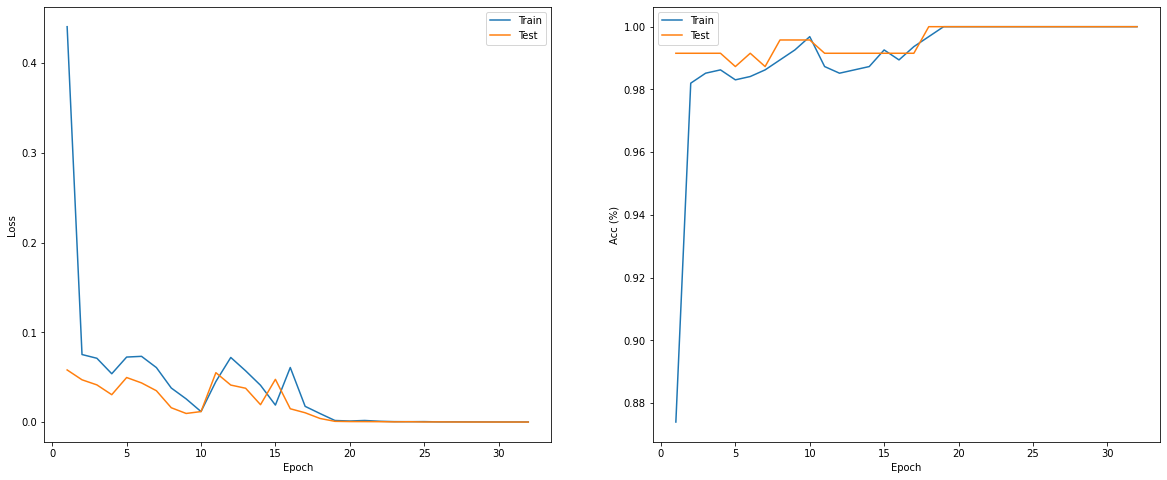

In [14]:
hist = trainingRet.history

fig, ax = plt.subplots(1, 2, figsize=(20,8))
epochs = range(1,N_EPOCH+1)

ax[0].plot(epochs,hist['loss'])
ax[0].plot(epochs,hist['val_loss'])
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train','Test'])

ax[1].plot(epochs,hist['accuracy'])
ax[1].plot(epochs,hist['val_accuracy'])
ax[1].set_ylabel('Acc (%)')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train','Test'])

plt.show()